# SE-Snek: SE-Sync Python bindings 🐍

This notebook demonstrates the use of SE-Sync's Python bindings

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

Import the sesync Python library build using pybind

In [2]:
sesync_lib_path = "../build/lib"  # Relative path to libraries built by the SE-Sync CMake project
sys.path.insert(0, sesync_lib_path)  # Add this directory to Python interpreter path

In [3]:
import sesync

Load in some data from a .g2o file

In [4]:
filename = "../../data/manhattan.g2o"

measurements, num_poses = sesync.read_g2o_file(filename)

print("Loaded %d measurements between %d poses from file %s" % (len(measurements), num_poses, filename))

Loaded 5453 measurements between 3500 poses from file ../../data/manhattan.g2o


**Run SE-Sync!**

Set SE-Sync options

In [5]:
opts = sesync.SESyncOpts()
#opts.r0 = 2
opts.num_threads = 4
#opts.initialization = sesync.Initialization.Random

In [6]:
result = sesync.SESync(measurements, opts)

Print out some interesting stats

In [7]:
print("SESync return status: %s\n\n\
Initial relaxation rank: %d\n\
Final relaxation rank: %d\n\
Value of dual SDP solution F(Y):  %g\n\
Norm of Riemannian gradient gradF(Y): %g\n\
Value of primal SDP solution tr(Lambda): %g\n\
Minimum eigenvalue of certificate matrix: %g\n\
SDP duality gap: %g\n\n\
Value of rounded pose estimates F(x): %g\n\
Suboptimality bound of recovered pose estimates: %g\n\n\
Total elapsed computation time: %g seconds " % (result.status, opts.r0, result.Yopt.shape[0], result.SDPval, result.gradnorm, 
         result.trLambda, result.lambda_min, result.duality_gap, 
        result.Fxhat, result.suboptimality_bound, result.total_computation_time))

SESync return status: SESyncStatus.GlobalOpt

Initial relaxation rank: 5
Final relaxation rank: 5
Value of dual SDP solution F(Y):  6431.39
Norm of Riemannian gradient gradF(Y): 0.000952599
Value of primal SDP solution tr(Lambda): 6431.39
Minimum eigenvalue of certificate matrix: 3.89991e-09
SDP duality gap: -9.09495e-13

Value of rounded pose estimates F(x): 6431.39
Suboptimality bound of recovered pose estimates: -3.66526e-10

Total elapsed computation time: 2.364 seconds 


**Plot some interesting data about the solution process**

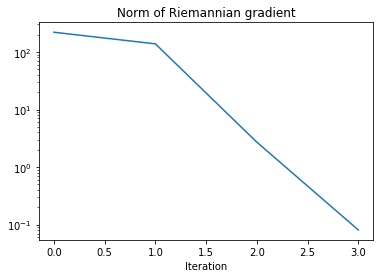

In [8]:
# Plot sequence of Riemannian gradient norms
grad_norms = np.concatenate(result.gradient_norms)
plt.semilogy(grad_norms)
plt.title("Norm of Riemannian gradient")
plt.xlabel("Iteration")
plt.show()

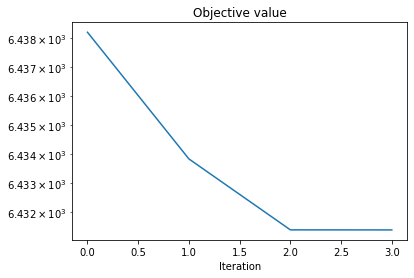

In [9]:
# Plot sequence of objective values
fvals = np.concatenate(result.function_values)
plt.semilogy(fvals)
plt.title("Objective value")
plt.xlabel("Iteration")
plt.show()

**Plot estimated SLAM solution**

In [10]:
# Extract translational states from solution xhat
xhat = result.xhat
R0inv = np.linalg.inv(xhat[:, num_poses : num_poses + 2])
t = np.matmul(R0inv, xhat[:, 0:num_poses])

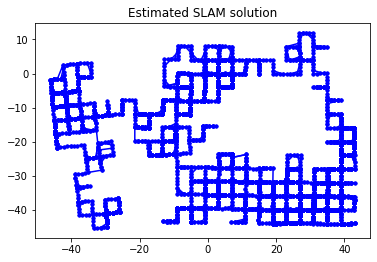

In [12]:
for k in range(0, len(measurements)):
    plt.plot(t[0, [measurements[k].i, measurements[k].j]], t[1, [measurements[k].i, measurements[k].j]], '.-b')

plt.title("Estimated SLAM solution")

plt.gca().set_aspect('equal')
plt.show()